In [44]:
from PIL import Image
from transformers import pipeline
import numpy as np
from pathlib import Path

import cv2

In [45]:
import cv2
import torch
import numpy as np
import matplotlib

import time
from picamera2 import Picamera2
from libcamera import Transform
import matplotlib.pyplot as plt

# import from folder Depth-Anything-V2/depth_anything_v2/
from depth_anything_v2.dpt import DepthAnythingV2


In [46]:

model = None
def init():
    global model
# small, base, 
    model_configs = {
        'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
        'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
        'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]}
    }

    encoder = 'vits' # or 'vits', 'vitb'
    dataset = 'hypersim' # 'hypersim' for indoor model, 'vkitti' for outdoor model
    max_depth = 20 # 20 for indoor model, 80 for outdoor model

    #! removed max depth
    model = DepthAnythingV2(**{**model_configs[encoder], 'max_depth': max_depth})
    # download models from: 
    model.load_state_dict(torch.load(f'checkpoints/depth_anything_v2_metric_{dataset}_{encoder}.pth', map_location='cpu'))
    model.eval()




def calculateDepth(picam_array):
    global original_depth
    raw_img = picam_array

    start_time = time.time()
    original_depth = model.infer_image(raw_img) # HxW depth map in meters in numpy
    end_time = time.time()

    print(f"Inference time: {end_time - start_time} seconds")

    depth = original_depth.copy()
    depth = (depth - depth.min()) / (depth.max() - depth.min()) * 255.0
    depth = depth.astype(np.uint8)
    cmap = matplotlib.colormaps.get_cmap('Spectral')

    depth = (cmap(depth)[:, :, :3] * 255)[:, :, ::-1].astype(np.uint8)

    cv2.imwrite('output/metric_depth_map.png', depth)


    model_base = original_depth.copy()


    # plt.imshow(original_depth)
    # plt.colorbar(label='Depth (m)')

    return np.array(model_base)





# init()
# estimate(bottleFrameDetected, bottleBox, bottleMask, segmentResults)

# test: adding 13.5cm to entire image, vs just adding 13.5cm at the end


In [47]:

def evalSideHelper(index, r):
    def get_center(c):
        moments = cv2.moments(c.masks.xy.pop().astype(np.int32).reshape(-1, 1, 2))
        if moments["m00"] != 0:
            return moments["m10"] / moments["m00"]
        return None

    centers = []
    for i, c in enumerate(r):
        center = get_center(c)
        if center is not None:
            centers.append((center, i))
    centers = sorted(centers)

    if len(centers) == 3:
        if centers[0][1] == index:
            return "left"
        elif centers[1][1] == index:
            return "center"
        else:
            return "right"
    elif len(centers) == 2:
        if centers[0][1] == index:
            return "left"
        else:
            return "right"

In [48]:
from PIL import Image
from transformers import pipeline
import numpy as np
import matplotlib.pyplot as plt

pipe = None

# for debug purposes
depthImage = None 

def estimate(picam_array, bottleBox, masks, res):
    global depthImage
    
    print("Starting depth estimation. This will take about 20-30 seconds")
    depthImage = calculateDepth(picam_array)
    # values are: avarage, maximum, centerpoint
    depth_values = {
        "left": [None, None, None],
        "center": [None, None, None],
        "right": [None, None, None]
    }



    # Iterate detection results 
    for r in res:

        img = np.copy(r.orig_img)
        img_name = Path(r.path).stem

        # Iterate each object contour 
        for ci, c in enumerate(r):
            label = c.names[c.boxes.cls.tolist().pop()]
            print(f"{ci + 1}. {label}")
            
            sideString = "center"
            if len(r) > 1:
                sideString = evalSideHelper(ci, r)



            # just a full black mask
            b_mask = np.zeros(img.shape[:2], np.uint8)


            # Create contour mask 
            contour = c.masks.xy[0].astype(np.int32).reshape(-1, 1, 2)
            _ = cv2.drawContours(b_mask, [contour], -1, (255, 255, 255), cv2.FILLED)

            # Calculate the center point of the contour
            M = cv2.moments(contour)
            if M["m00"] != 0:
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
            else:
                cX, cY = 0, 0
            print(f"Center point of the contour: ({cX}, {cY})")

            # get depth at centerpoint
            depthAtBottleCenter = depthImage[cY, cX]


            # Choose one:

            # OPTION-1: Isolate object with black background
            # mask3ch = cv2.cvtColor(b_mask, cv2.COLOR_GRAY2BGR)
            # isolated = cv2.bitwise_and(mask3ch, img)


            # Convert depthImage to 3-channel image
            # depthImage_3ch = cv2.cvtColor(depthImage, cv2.COLOR_GRAY2BGR)
            
            isolated = cv2.bitwise_and(depthImage, depthImage, mask=b_mask)
            
            # Calculate the average depth value for the masked object
            masked_depth = cv2.bitwise_and(depthImage, depthImage, mask=b_mask)
            average_depth = cv2.mean(masked_depth, mask=b_mask)[0]


            # add to depth_values
            depth_values[sideString][0] = average_depth
            # max depth of masked_depth
            depth_values[sideString][1] = masked_depth.max()
            depth_values[sideString][2] = depthAtBottleCenter

            print(f"Average depth of the object: {average_depth}")

            calibratedDistance = 0.15
            print(f"For calibration, adding {calibratedDistance}: {average_depth + calibratedDistance}")



            # Display the isolated object using matplotlib
            plt.imshow(isolated)
            plt.axis('off')
            plt.show()

    return depth_values

     




In [49]:
import cv2
from picamera2 import Picamera2

from ultralytics import YOLO
from libcamera import Transform
import time

# from depthest import init, estimate

In [50]:
def runModel():
    bottleFrameDetected, bottleBox, bottleMask, segmentResults = None, None, None, None

    finalEstimates = None
    print("init")
    with Picamera2() as picam2:
        # Initialize the Picamera2
        # picam2 = Picamera2()

        # default
        # picam2.preview_configuration.main.size = (1280, 720)
        picam2.preview_configuration.main.size = (640, 310)
        # picam2.preview_configuration.main.size = (640 /2, 310/2)

        picam2.preview_configuration.main.format = "RGB888"
        picam2.preview_configuration.align()
        picam2.preview_configuration.transform=Transform(vflip=1)
        picam2.configure("preview")
        picam2.start()


        # Load the YOLO11 model
        # have to run create model first 
        segmentModel = YOLO("yolo11n-seg.pt")  
        model = YOLO("yolo11n-cls.pt")

        instantBreak = False


        # used to record the time when we processed last frame 
        prev_frame_time = 0
        
        # used to record the time at which we processed current frame 
        new_frame_time = 0
        # font which we will be using to display FPS 
        font = cv2.FONT_HERSHEY_SIMPLEX 

        bottleFrameDetected = None
        bottleFrameNew = None

        results = None
        bottleBox = None

        while True:
            # time when we finish processing for this frame 
            # ! do all processing below this, and above the fps calculator
            new_frame_time = time.time() 

            # Capture frame-by-frame
            frame = picam2.capture_array()

            # Run YOLO11 inference on the frame
            results = model(frame)

            # print(results)
            # Visualize the results on the frame
            # annotated_frame = results[0].plot()

            new_frame_time = time.time() 
        
            # Calculating the fps 
            fps = 1/(new_frame_time-prev_frame_time) 
            prev_frame_time = new_frame_time 
            fps = int(fps) 
            fps = str(fps) 
            # cv2.putText(annotated_frame, fps, (7, 70), font, 3, (100, 255, 0), 3, cv2.LINE_AA) 
            print(fps)
            # Check if a bottle has been recognized
            for result in results:
                # probs = result.probs  # Probs object for classification outputs
                # print(probs)
                # classification model
                if result.probs != None:
                    # print("Top 5 classes", result.probs.top5)
                    # https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a
                    # 440: beer_bottle
                    # 898: water bottle
                    if 898 in result.probs.top5:
                        print("Bottle found with class index 898")
                        bottleFrameDetected = frame
                        instantBreak = True
                        break;


                # for detection in result.boxes:
                # #     # Assuming detection.cls is an integer index for the class
                #     bottleBox = detection
                #     if detection.cls == 39:  # correct class index for "bottle"
                #         print("Bottle recognized", )
                #         print("Probabilty", detection.conf)
                #         bottleFrameDetected = frame
                #         instantBreak = True
                #         break


            # Display the resulting frame
            # cv2.imshow("Camera", annotated_frame)

            if instantBreak:
                break
            # Break the loop if 'q' is pressed
            if cv2.waitKey(1) == ord("q"):
                print("")
                break

        # Release resources and close windows
        cv2.destroyAllWindows()

        # https://docs.ultralytics.com/modes/predict/#__tabbed_1_1
        if bottleFrameDetected is not None:
            # Capture a new frame of the bottle
            # should not be blurry
            bottleFrameNew = picam2.capture_array()
            cv2.imwrite("output/bottle_new.png", bottleFrameNew)

        # Process results list
        # results for bottleFrameDetected
        for result in results:
            boxes = result.boxes  # Boxes object for bounding box outputs
            masks = result.masks  # Masks object for segmentation masks outputs
            keypoints = result.keypoints  # Keypoints object for pose outputs
            probs = result.probs  # Probs object for classification outputs
            obb = result.obb  # Oriented boxes object for OBB outputs
            # result.show()  # display to screen
            result.save(filename="output/bottle_detected.png")  # save to disk

        # segmnet
        segmentResults = segmentModel.predict(source=bottleFrameDetected, classes=39)
        bottleMask = None
        # Process results list
        for result in segmentResults:
            result.save(filename="output/segmented.jpg")  # save to disk

            if (result.masks.shape[0] > 3) :
                print("More than three bottles detected. Evaluation helper function can't handle more than three bottles..")


            bottleMask = result.masks[0]  # Masks object for segmentation masks outputs

        init()
        finalEstimates = estimate(bottleFrameDetected, bottleBox, bottleMask, segmentResults)




    # Stop the camera to free up resources
    picam2.stop() 
    picam2.stop_encoder()

    del picam2

    return finalEstimates


init


[0:55:52.362835008] [9365]  INFO Camera camera_manager.cpp:325 libcamera v0.3.2+99-1230f78d
[0:55:52.392845182] [15464]  WARN RPiSdn sdn.cpp:40 Using legacy SDN tuning - please consider moving SDN inside rpi.denoise
[0:55:52.394784780] [15464]  INFO RPI vc4.cpp:447 Registered camera /base/soc/i2c0mux/i2c@1/imx708@1a to Unicam device /dev/media4 and ISP device /dev/media1
[0:55:52.394846243] [15464]  INFO RPI pipeline_base.cpp:1120 Using configuration file '/usr/share/libcamera/pipeline/rpi/vc4/rpi_apps.yaml'
[0:55:52.422950022] [9365]  INFO Camera camera.cpp:1197 configuring streams: (0) 640x310-RGB888 (1) 1536x864-SGRBG10_CSI2P
[0:55:52.423452889] [15464]  INFO RPI vc4.cpp:622 Sensor: /base/soc/i2c0mux/i2c@1/imx708@1a - Selected sensor format: 1536x864-SGRBG10_1X10 - Selected unicam format: 1536x864-pgAA



0: 224x224 water_bottle 0.86, nipple 0.03, pop_bottle 0.03, cocktail_shaker 0.02, water_jug 0.02, 107.2ms
Speed: 19.5ms preprocess, 107.2ms inference, 0.3ms postprocess per image at shape (1, 3, 224, 224)
0
Bottle found with class index 898

0: 320x640 3 bottles, 900.8ms
Speed: 5.5ms preprocess, 900.8ms inference, 21.6ms postprocess per image at shape (1, 3, 320, 640)
Starting depth estimation. This will take about 20-30 seconds
Inference time: 26.2101571559906 seconds
1. bottle
Center point of the contour: (364, 162)
Average depth of the object: 1.0334739006487013
For calibration, adding 0.15: 1.1834739006487012


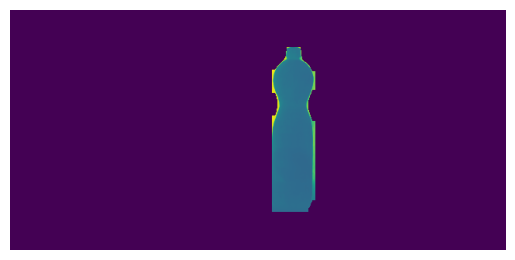

2. bottle
Center point of the contour: (489, 168)
Average depth of the object: 1.2946604062808686
For calibration, adding 0.15: 1.4446604062808686


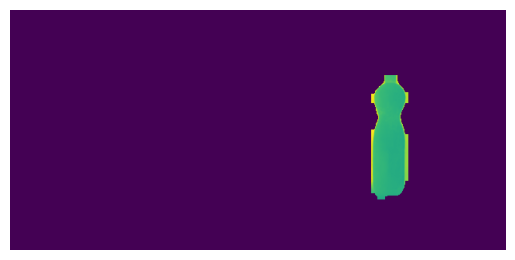

3. bottle
Center point of the contour: (170, 151)
Average depth of the object: 0.7153734621653145
For calibration, adding 0.15: 0.8653734621653145


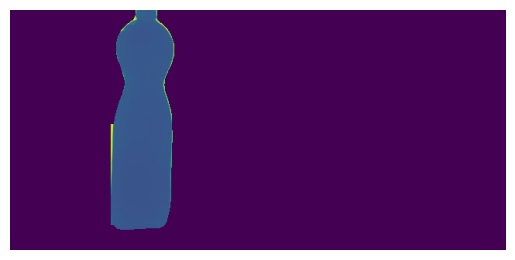

Bottle: left
Average depth: 0.7153734621653145
Max depth: 2.46753191947937
Depth at centerpoint: 0.6665598154067993


Bottle: center
Average depth: 1.0334739006487013
Max depth: 2.549809455871582
Depth at centerpoint: 0.9095099568367004


Bottle: right
Average depth: 1.2946604062808686
Max depth: 1.9159011840820312
Depth at centerpoint: 1.1980997323989868


init


[0:59:05.926253732] [9365]  INFO Camera camera_manager.cpp:325 libcamera v0.3.2+99-1230f78d
[0:59:05.957418584] [16309]  WARN RPiSdn sdn.cpp:40 Using legacy SDN tuning - please consider moving SDN inside rpi.denoise
[0:59:05.959282053] [16309]  INFO RPI vc4.cpp:447 Registered camera /base/soc/i2c0mux/i2c@1/imx708@1a to Unicam device /dev/media4 and ISP device /dev/media1
[0:59:05.959339312] [16309]  INFO RPI pipeline_base.cpp:1120 Using configuration file '/usr/share/libcamera/pipeline/rpi/vc4/rpi_apps.yaml'
[0:59:05.982778492] [9365]  INFO Camera camera.cpp:1197 configuring streams: (0) 640x310-RGB888 (1) 1536x864-SGRBG10_CSI2P
[0:59:05.983237823] [16309]  INFO RPI vc4.cpp:622 Sensor: /base/soc/i2c0mux/i2c@1/imx708@1a - Selected sensor format: 1536x864-SGRBG10_1X10 - Selected unicam format: 1536x864-pgAA



0: 224x224 water_bottle 0.82, nipple 0.03, pop_bottle 0.03, cocktail_shaker 0.03, water_jug 0.03, 105.6ms
Speed: 48.0ms preprocess, 105.6ms inference, 0.3ms postprocess per image at shape (1, 3, 224, 224)
0
Bottle found with class index 898

0: 320x640 2 bottles, 774.6ms
Speed: 5.6ms preprocess, 774.6ms inference, 10.5ms postprocess per image at shape (1, 3, 320, 640)
Starting depth estimation. This will take about 20-30 seconds
Inference time: 26.11888861656189 seconds
1. bottle
Center point of the contour: (365, 162)
Average depth of the object: 1.0353018445834723
For calibration, adding 0.15: 1.1853018445834722


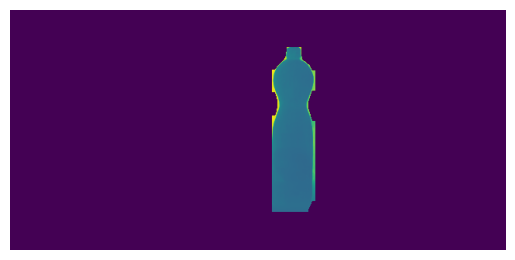

2. bottle
Center point of the contour: (489, 168)
Average depth of the object: 1.2974718053740375
For calibration, adding 0.15: 1.4474718053740374


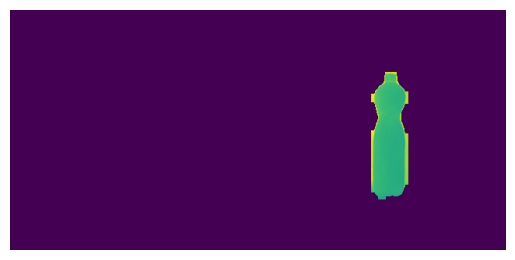

Bottle: left
Average depth: 1.0353018445834723
Max depth: 2.5341975688934326
Depth at centerpoint: 0.9156239032745361


Bottle: center
Average depth: None
Max depth: None
Depth at centerpoint: None


Bottle: right
Average depth: 1.2974718053740375
Max depth: 1.895211100578308
Depth at centerpoint: 1.2007745504379272


init


[1:00:07.913961244] [9365]  INFO Camera camera_manager.cpp:325 libcamera v0.3.2+99-1230f78d
[1:00:07.943277979] [16798]  WARN RPiSdn sdn.cpp:40 Using legacy SDN tuning - please consider moving SDN inside rpi.denoise
[1:00:07.945185170] [16798]  INFO RPI vc4.cpp:447 Registered camera /base/soc/i2c0mux/i2c@1/imx708@1a to Unicam device /dev/media4 and ISP device /dev/media1
[1:00:07.945248780] [16798]  INFO RPI pipeline_base.cpp:1120 Using configuration file '/usr/share/libcamera/pipeline/rpi/vc4/rpi_apps.yaml'
[1:00:07.969641195] [9365]  INFO Camera camera.cpp:1197 configuring streams: (0) 640x310-RGB888 (1) 1536x864-SGRBG10_CSI2P
[1:00:07.970792410] [16798]  INFO RPI vc4.cpp:622 Sensor: /base/soc/i2c0mux/i2c@1/imx708@1a - Selected sensor format: 1536x864-SGRBG10_1X10 - Selected unicam format: 1536x864-pgAA



0: 224x224 water_bottle 0.81, nipple 0.04, pop_bottle 0.03, cocktail_shaker 0.03, water_jug 0.03, 112.1ms
Speed: 39.4ms preprocess, 112.1ms inference, 0.3ms postprocess per image at shape (1, 3, 224, 224)
0
Bottle found with class index 898

0: 320x640 2 bottles, 800.2ms
Speed: 6.1ms preprocess, 800.2ms inference, 12.3ms postprocess per image at shape (1, 3, 320, 640)
Starting depth estimation. This will take about 20-30 seconds
Inference time: 26.01224184036255 seconds
1. bottle
Center point of the contour: (365, 162)
Average depth of the object: 1.0042217334376569
For calibration, adding 0.15: 1.1542217334376568


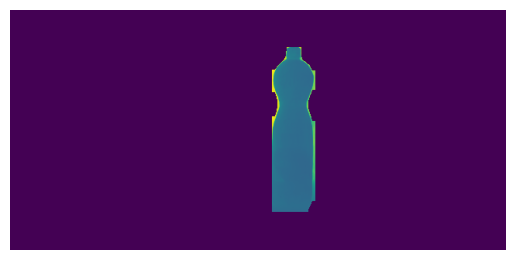

2. bottle
Center point of the contour: (489, 168)
Average depth of the object: 1.2615477892048939
For calibration, adding 0.15: 1.4115477892048938


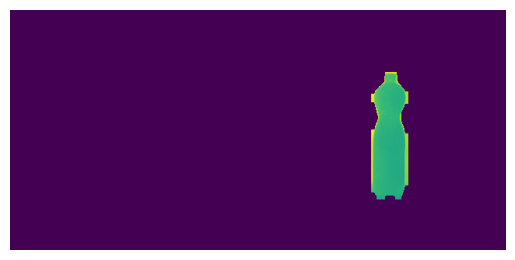

Bottle: left
Average depth: 1.0042217334376569
Max depth: 2.5045125484466553
Depth at centerpoint: 0.8838499784469604


Bottle: center
Average depth: None
Max depth: None
Depth at centerpoint: None


Bottle: right
Average depth: 1.2615477892048939
Max depth: 1.872636079788208
Depth at centerpoint: 1.159580945968628


init


[1:00:59.494602432] [9365]  INFO Camera camera_manager.cpp:325 libcamera v0.3.2+99-1230f78d
[1:00:59.523580613] [17220]  WARN RPiSdn sdn.cpp:40 Using legacy SDN tuning - please consider moving SDN inside rpi.denoise
[1:00:59.525508767] [17220]  INFO RPI vc4.cpp:447 Registered camera /base/soc/i2c0mux/i2c@1/imx708@1a to Unicam device /dev/media4 and ISP device /dev/media1
[1:00:59.525574489] [17220]  INFO RPI pipeline_base.cpp:1120 Using configuration file '/usr/share/libcamera/pipeline/rpi/vc4/rpi_apps.yaml'
[1:00:59.547784047] [9365]  INFO Camera camera.cpp:1197 configuring streams: (0) 640x310-RGB888 (1) 1536x864-SGRBG10_CSI2P
[1:00:59.548247729] [17220]  INFO RPI vc4.cpp:622 Sensor: /base/soc/i2c0mux/i2c@1/imx708@1a - Selected sensor format: 1536x864-SGRBG10_1X10 - Selected unicam format: 1536x864-pgAA



0: 224x224 water_bottle 0.82, nipple 0.04, cocktail_shaker 0.03, pop_bottle 0.03, water_jug 0.02, 103.1ms
Speed: 25.9ms preprocess, 103.1ms inference, 0.2ms postprocess per image at shape (1, 3, 224, 224)
0
Bottle found with class index 898

0: 320x640 2 bottles, 807.0ms
Speed: 7.4ms preprocess, 807.0ms inference, 9.4ms postprocess per image at shape (1, 3, 320, 640)
Starting depth estimation. This will take about 20-30 seconds
Inference time: 26.31284523010254 seconds
1. bottle
Center point of the contour: (365, 162)
Average depth of the object: 1.037918244665117
For calibration, adding 0.15: 1.1879182446651169


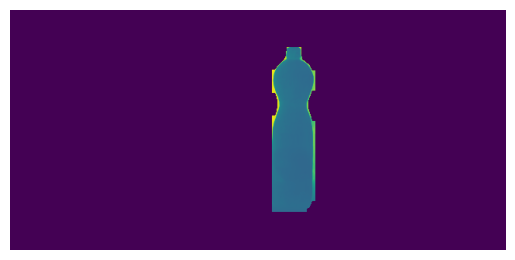

2. bottle
Center point of the contour: (489, 169)
Average depth of the object: 1.307376976687574
For calibration, adding 0.15: 1.457376976687574


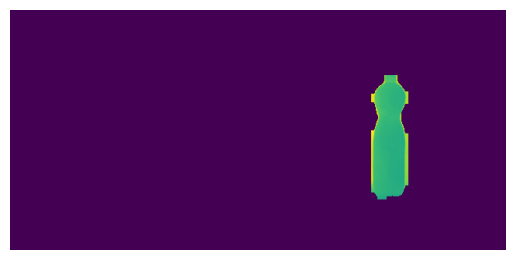

Bottle: left
Average depth: 1.037918244665117
Max depth: 2.583887815475464
Depth at centerpoint: 0.9120171070098877


Bottle: center
Average depth: None
Max depth: None
Depth at centerpoint: None


Bottle: right
Average depth: 1.307376976687574
Max depth: 1.921316385269165
Depth at centerpoint: 1.2117388248443604


Run 1:
Bottle: left
Average depth: 0.7153734621653145
Max depth: 2.46753191947937
Depth at centerpoint: 0.6665598154067993


Bottle: center
Average depth: 1.0334739006487013
Max depth: 2.549809455871582
Depth at centerpoint: 0.9095099568367004


Bottle: right
Average depth: 1.2946604062808686
Max depth: 1.9159011840820312
Depth at centerpoint: 1.1980997323989868


Run 2:
Bottle: left
Average depth: 1.0353018445834723
Max depth: 2.5341975688934326
Depth at centerpoint: 0.9156239032745361


Bottle: center
Average depth: None
Max depth: None
Depth at centerpoint: None


Bottle: right
Average depth: 1.2974718053740375
Max depth: 1.895211100578308
Depth at centerpoint: 1.20077455

In [ ]:
def prettyprintEstimates(estimates):
  for side, values in estimates.items():
    print(f"Bottle: {side}")
    print(f"Average depth: {values[0]}")
    print(f"Max depth: {values[1]}")
    print(f"Depth at centerpoint: {values[2]}")
    print("\n")
    

# run entireModel 4 times
results = []
for _ in range(4):
  result = runModel()
  results.append(result)
  # prettyprintEstimates(result)

print('finished. printing!!!')
print('finished. printing!!!')
print('finished. printing!!!')

# Pretty print the results
for i, result in enumerate(results):
  print(f"Run {i + 1}:")
  prettyprintEstimates(result)


# calculate error
# calculate what is standard error
# depth vs error
# 
